Nama : Anindhita Nisitasari

# Set the Data

In [ ]:
# install package
!pip install -q kaggle
from google.colab import files
import io
import zipfile
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM

In [ ]:
! chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d jaganadhg/house-hold-energy-data

  0% 0.00/2.58M [00:00<?, ?B/s]
100% 2.58M/2.58M [00:00<00:00, 168MB/s]


In [ ]:
zip_file = zipfile.ZipFile('/content/house-hold-energy-data.zip', 'r')
zip_file.extractall('/tmp/')

In [ ]:
energydata_train = pd.read_csv("/tmp/D202.csv")
energydata_train.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [ ]:
# Mengetahui banyaknya data
energydata_train.shape

(70368, 8)

In [ ]:
# Mengecek apakah ada nilai Null atau tidak
energydata_train.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [ ]:
# Mengecek penggunaan Memori
print(energydata_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB
None


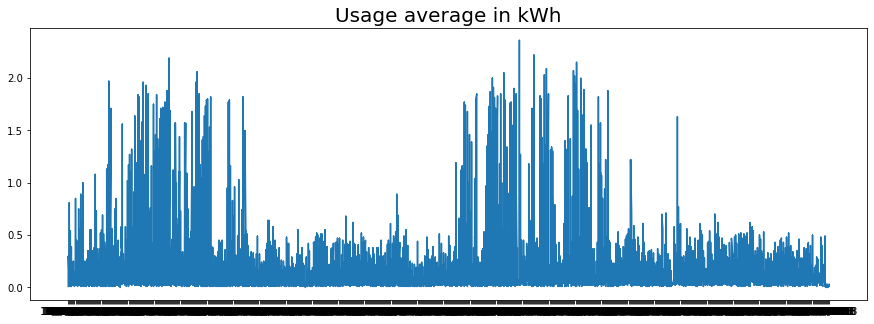

In [ ]:
dates = energydata_train['DATE'].values
usage  = energydata_train['USAGE'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, usage)
plt.title('Usage average in kWh',
          fontsize=20);

In [ ]:
energydata_train['DATE']=pd.to_datetime(energydata_train['DATE'])
energydata_train['DATE'].head()
energydata_train['USAGE'].fillna(energydata_train['USAGE'].mean(), inplace=True)
data = energydata_train[['DATE','USAGE']]
data.head()

,DATE,USAGE
0,2016-10-22,0.01
1,2016-10-22,0.01
2,2016-10-22,0.01
3,2016-10-22,0.01
4,2016-10-22,0.01


# Model

In [ ]:
data=energydata_train[['DATE','USAGE']].copy()
data['just_date'] = data['DATE'].dt.date

final=data.drop('DATE',axis=1)
final.set_index('just_date', inplace= True)
final.head()

,USAGE
just_date,
2016-10-22,0.01
2016-10-22,0.01
2016-10-22,0.01
2016-10-22,0.01
2016-10-22,0.01


In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70368 entries, 2016-10-22 to 2018-10-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USAGE   70368 non-null  float64
dtypes: float64(1)
memory usage: 1.1+ MB


In [ ]:
# data values
date = energydata_train['DATE'].values
usage = energydata_train['USAGE'].values

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(usage, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

56294 14074


arsitektur model gunakan 2 buah layer LSTM. Ketika menggunakan 2 buah layer LSTM, perhatikan bahwa layer pertama harus memiliki parameter return_sequences yang bernilai True.

In [ ]:
max =energydata_train['USAGE'].max()
print('Max total : ' )
print(max)

Max total : 
2.36


In [ ]:
min = energydata_train['USAGE'].min()
print('Min total: ')
print(min)

Min total: 
0.0


In [ ]:
x = (90.0 - 1.0) * (10 / 100)
print(x)

8.9


In [ ]:
# model
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# callback
class newCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = newCallback()

In [ ]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=50, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/50
    563/Unknown - 108s 191ms/step - loss: 0.1671 - mae: 0.3837
MAE of the model < 10% of data scale
563/563 [==============================] - 129s 227ms/step - loss: 0.1671 - mae: 0.3837 - val_loss: 0.0345 - val_mae: 0.1829
